In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
import imageio
import moviepy.video.io.ImageSequenceClip
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [3]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [4]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

# Load results

In [5]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [6]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [7]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:26<00:00, 18.76it/s]


# Plot brains

In [8]:
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [9]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [10]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']
    assert(list(sorted(color))==list(color))
    sc = ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                cmap="viridis",
                vmin=0.48,
                vmax=0.70,
                   )
    return sc

/tmp/ipykernel_2105105/1547264026.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


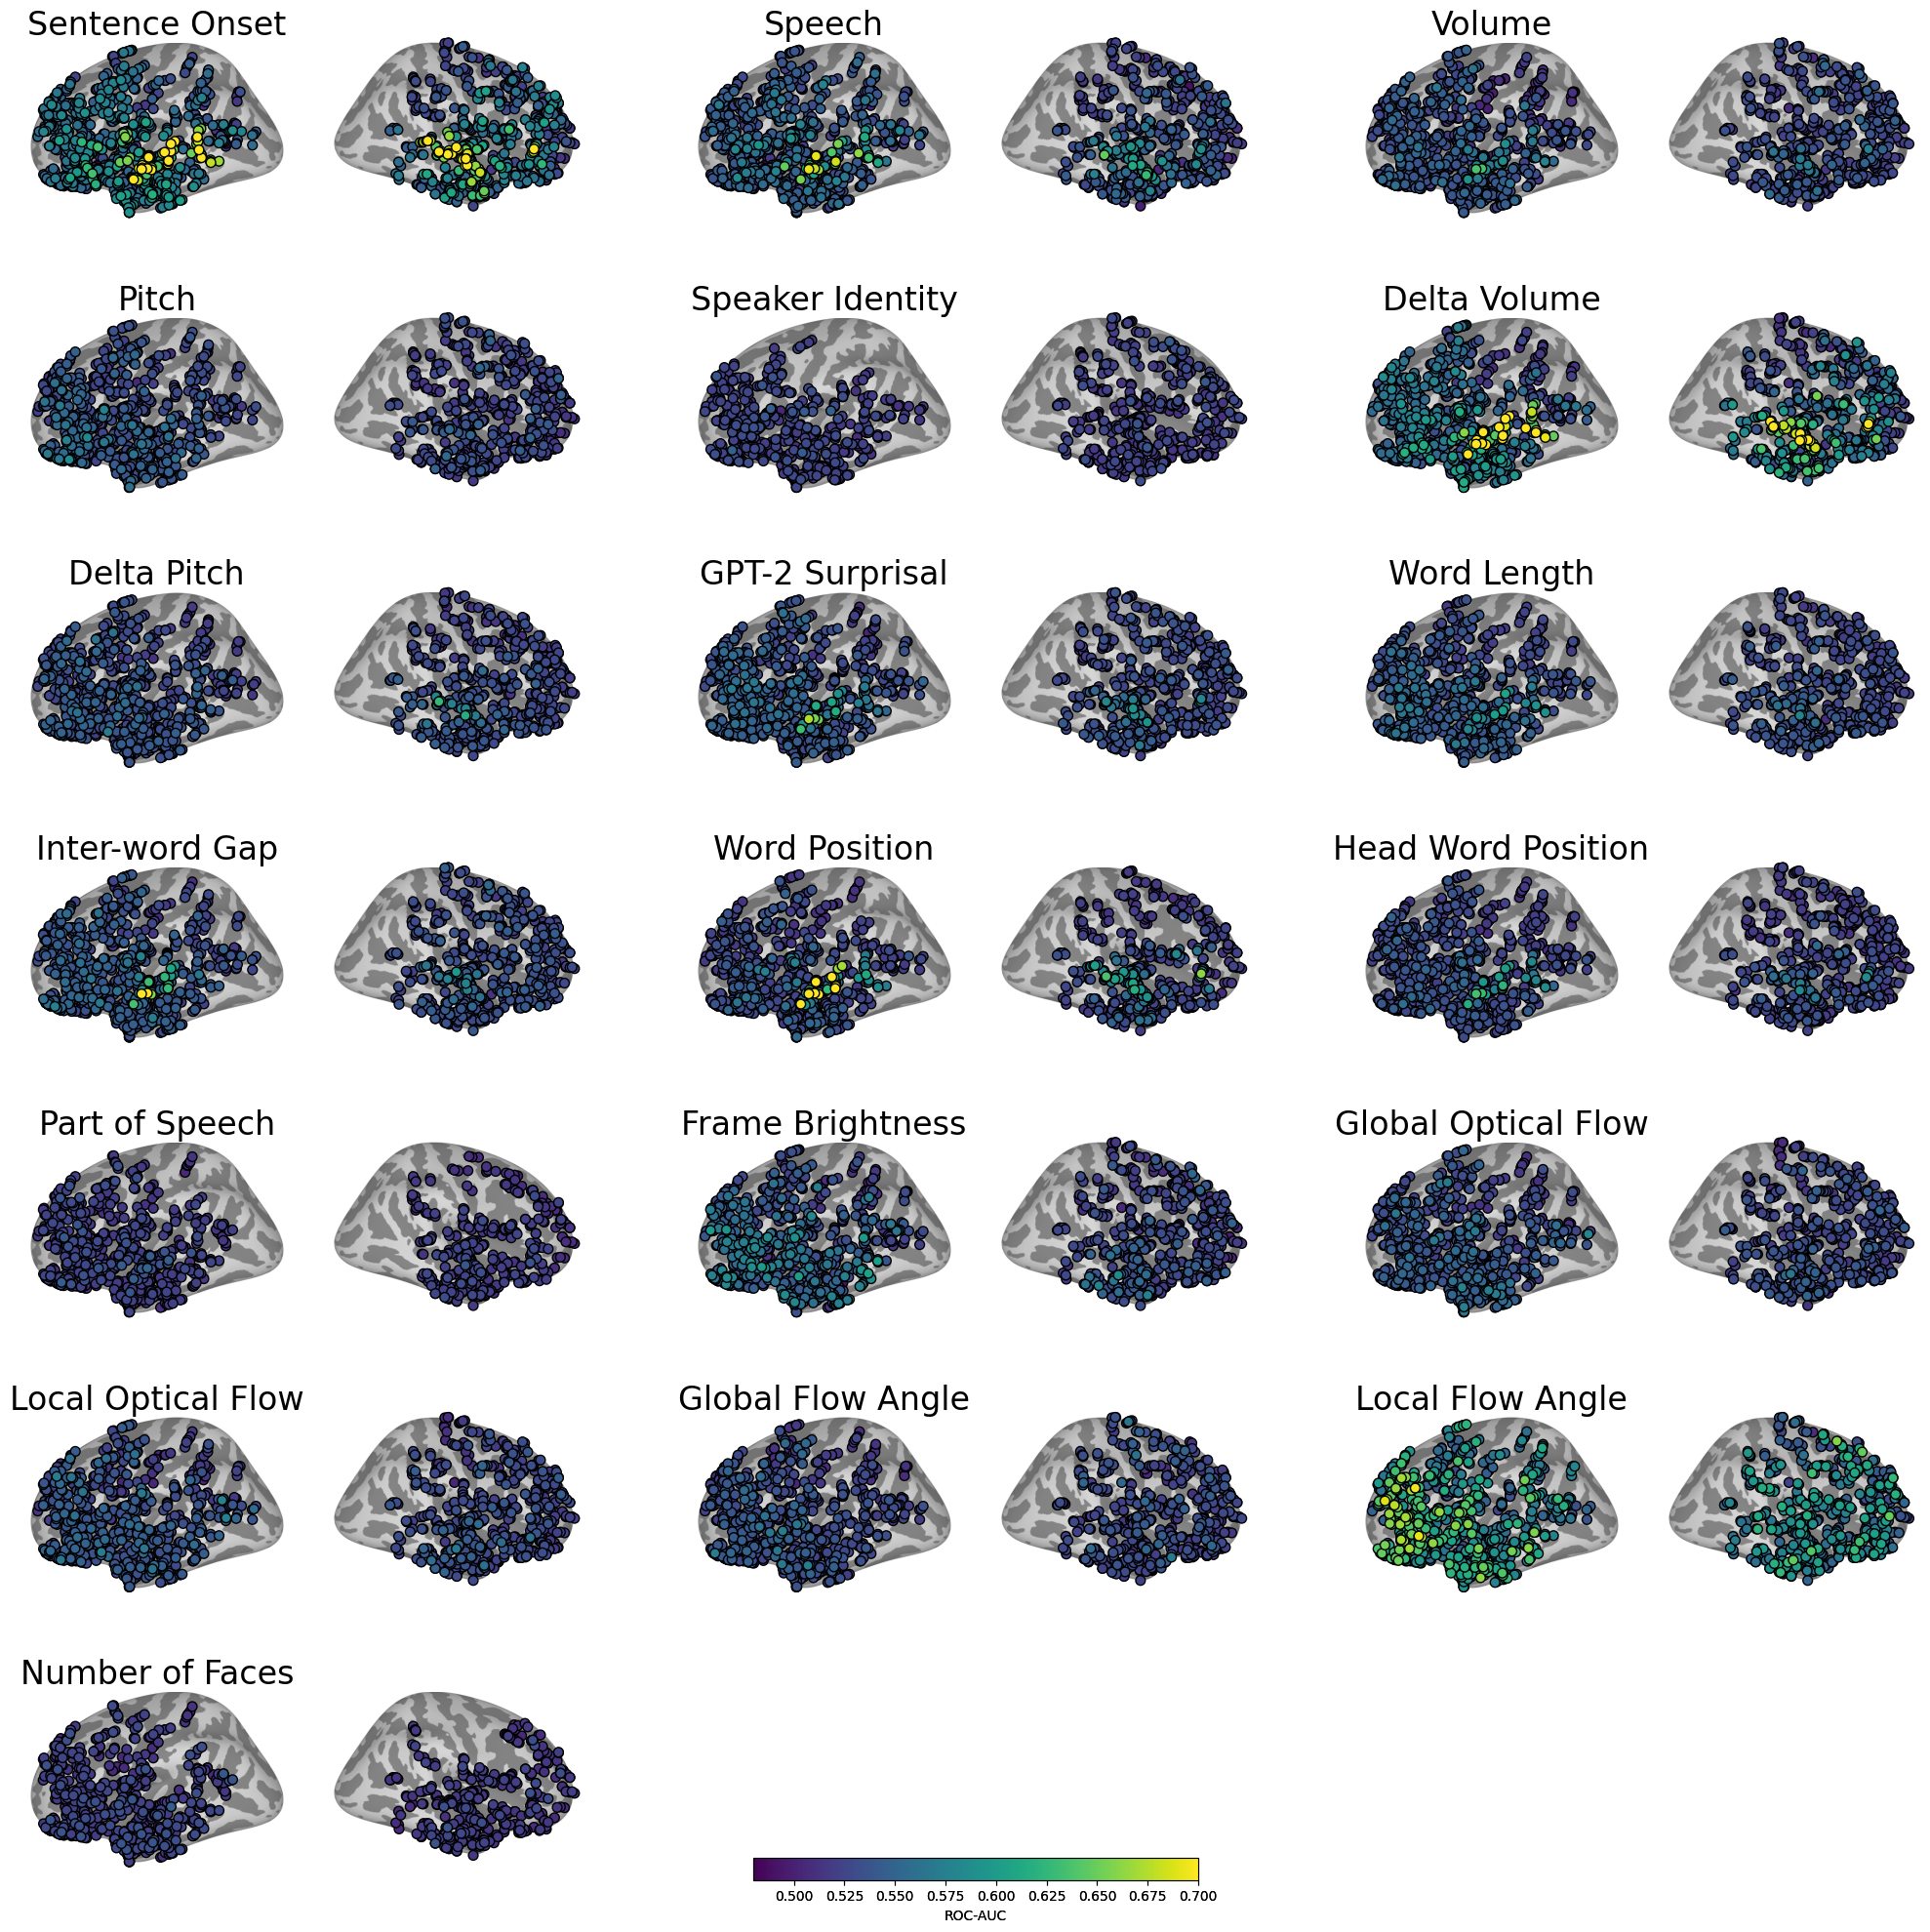

In [11]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 25))

num_cols = 3
num_rows = 7
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            ax = fig.add_subplot(outer[19])
            cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.8)
            cbar.set_label("ROC-AUC")
            ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            task = task_order[i*num_cols+j]
            task_df = spatial_avg_results_df.loc[task]
            # task_df.loc[:,'avg_test'] = np.log(100*task_df['avg_test'])
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
#             ax.set_title(task)
            
            if k == 0:
                ax.set_title(task_name_mapping[task], fontsize=24)
                
plt.tight_layout()

# Make time series 

/tmp/ipykernel_2105105/974333989.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


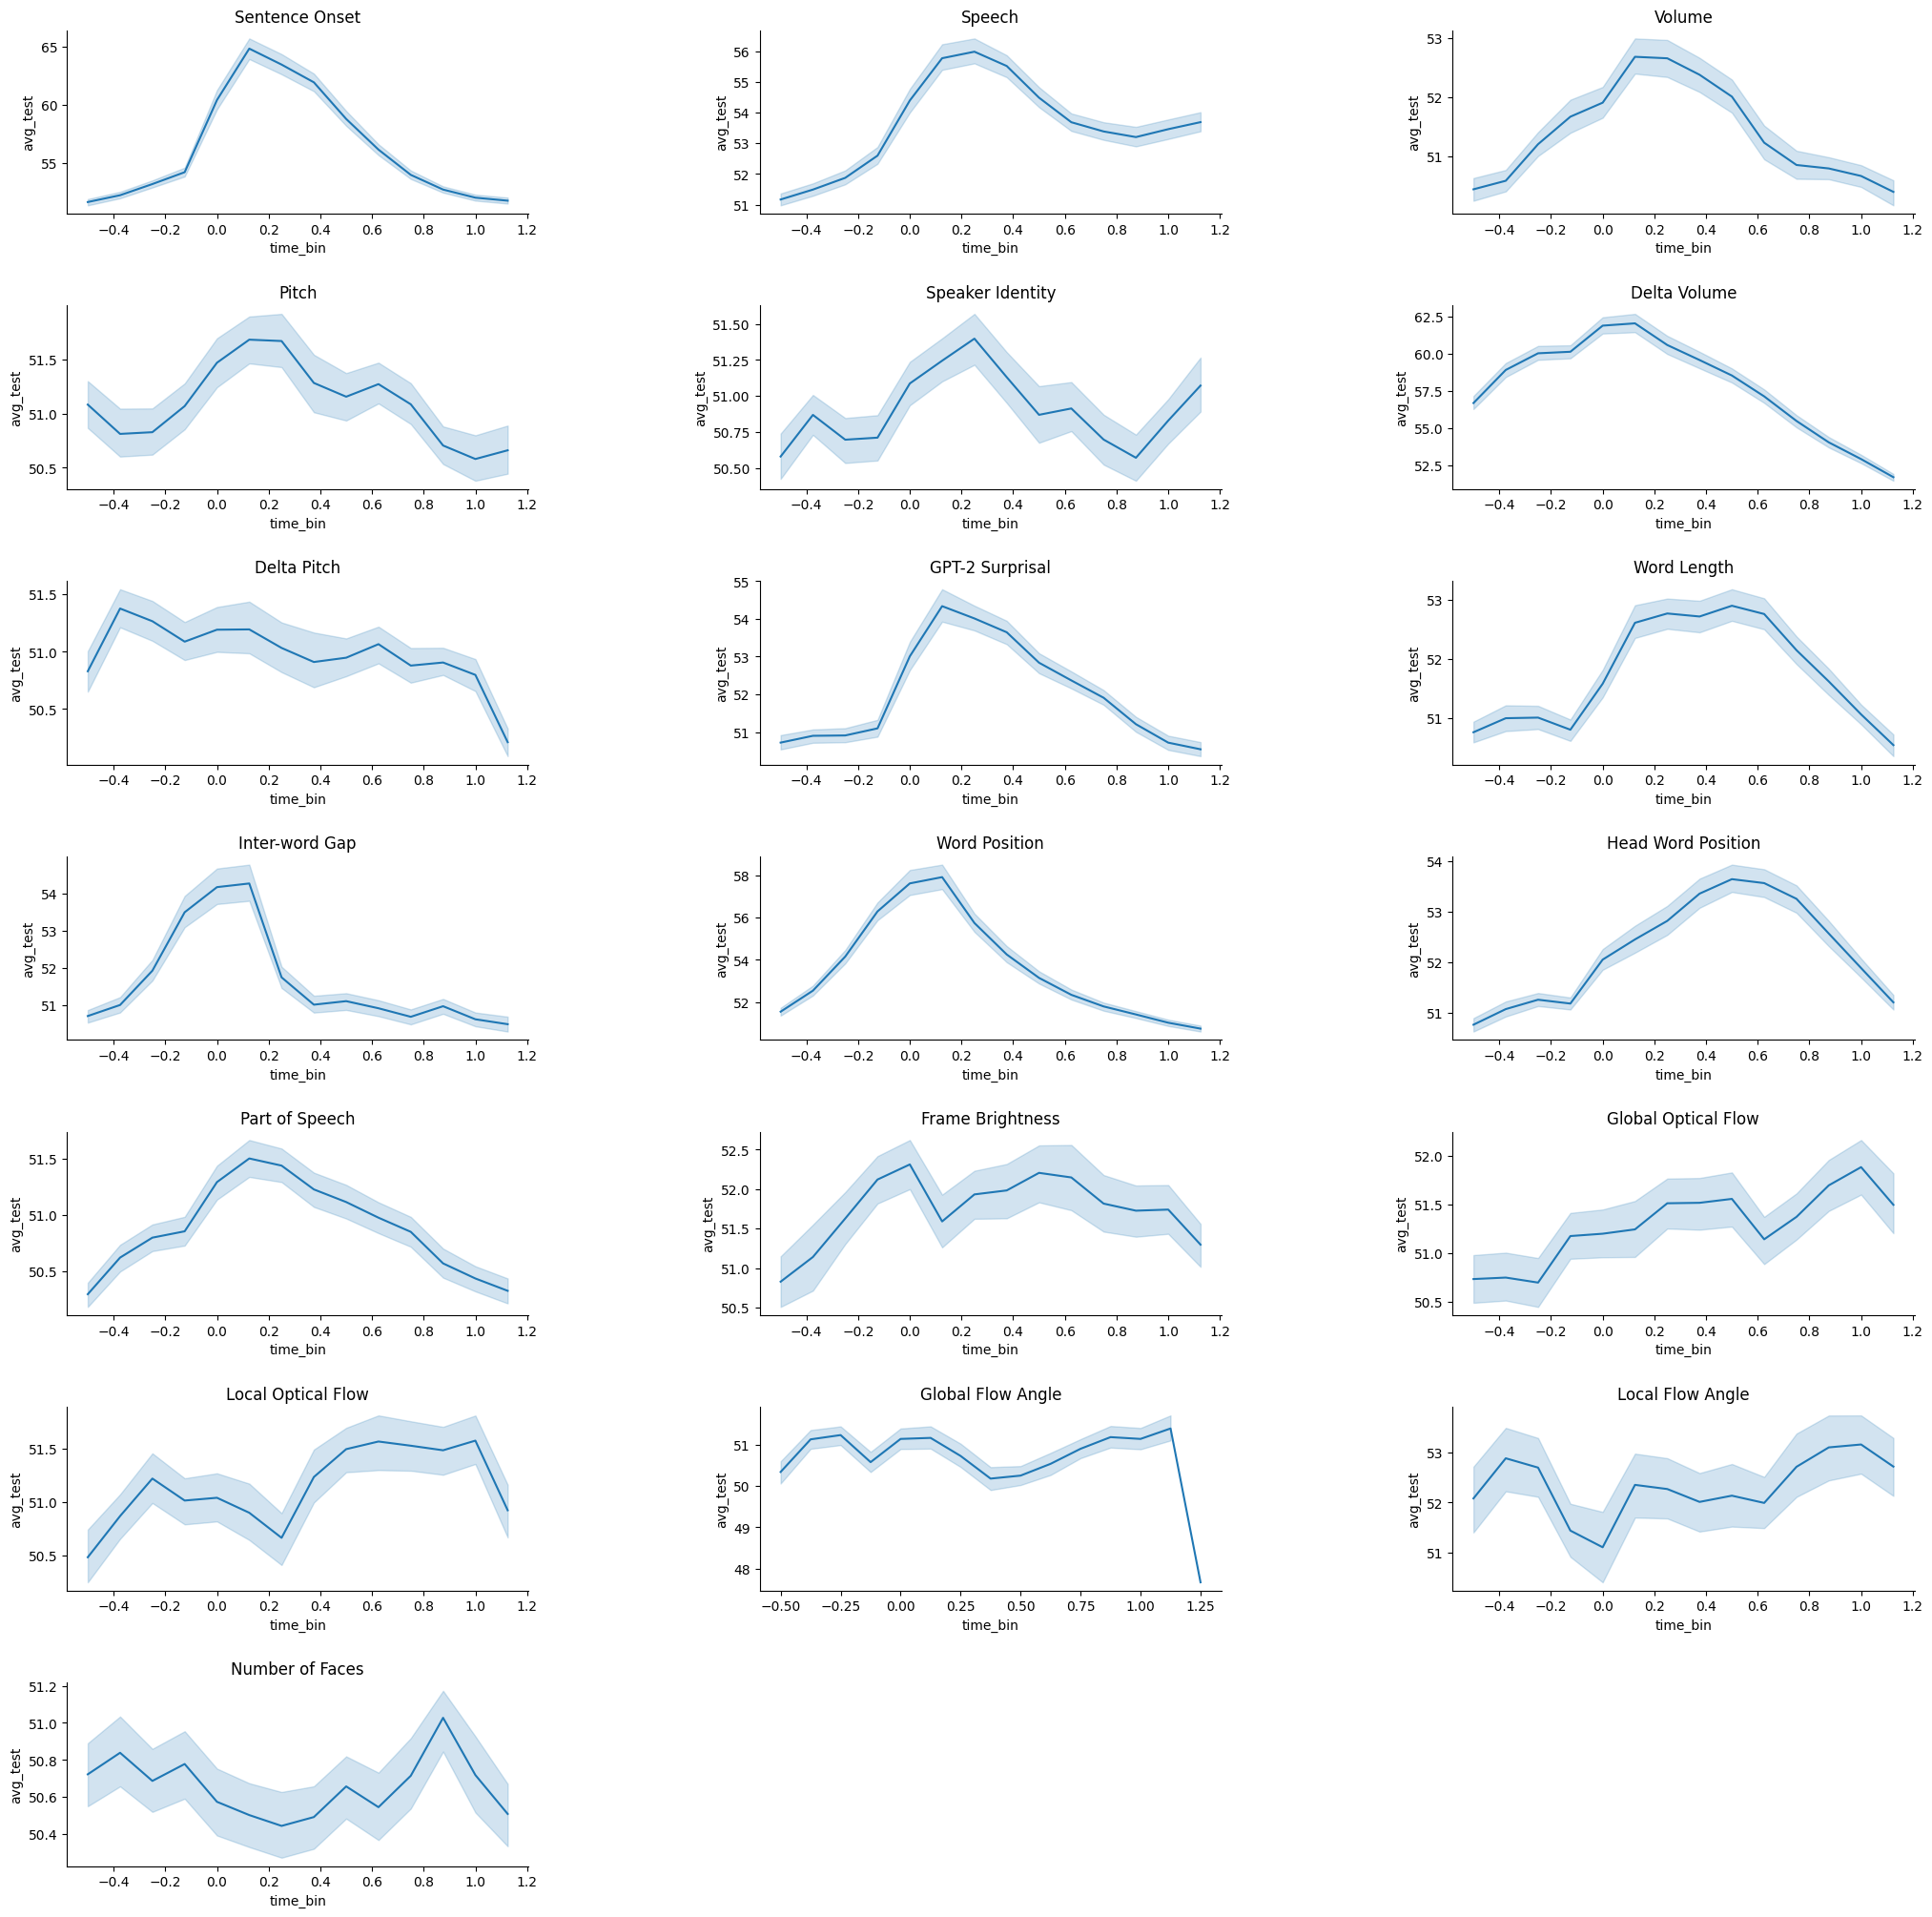

In [12]:
fig = plt.figure(figsize=(25, 25))

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.5, hspace=0.5)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            continue

        ax = fig.add_subplot(outer[outer_idx])
        task = task_order[i*num_cols+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean(["avg_test"])
#         good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
        time_df.loc[:,'avg_test'] = [(100*x) for x in time_df['avg_test']]
        
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        g = sns.lineplot(data=time_df, x="time_bin", y="avg_test")
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task_name_mapping[task])
        sns.despine() 
        # plt.yscale('log')
        # plt.ylim(50, 70)
        # for axes in g.axes:
        # ax.set_ylabel("ROC-AUC")plt.ticklabel_format(axis='y', style='plain')             # <---- error


# from matplotlib.ticker import ScalarFormatter
# plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        
        # from matplotlib.ticker import ScalarFormatter
        # plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
        # plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.tight_layout()